In [2]:
import sys
from os.path import join as oj
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.append('../src')
import numpy as np
import data_pecarn, data_psrc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

d = data_pecarn.get_data(use_processed=True, dummy=True, frac_missing_allowed=1, impute_feats=False)

![](../docs/ultrasound.png)

In [ ]:
y = d['iai_intervention']
meanings = ['<1%', '1-5%', '6-10%', '11-50%', ">50%", 'Physician did not answer']
# y

In [38]:
fast = d['UltrasoundType'] == 1
abnormal = d['UltrasoundRes'] == 2
# np.unique(d['UltrasoundRes'][fast], return_counts=True)
fast = (fast & (d['UltrasoundRes'] != 3)) # drop patients with "no interpretation"
# ((d['UltrasoundType'] == 1) & (d['UltrasoundRes'] == 3) & (d['iai'] == 1)).sum() # look at patients with no interpretation
fast_abnormal = fast & abnormal

In [37]:
print('# patients', d.shape[0])
print('# iai-i', y.sum())
print('# FAST (UltrasoundType==1)', fast.sum())
print('# FAST abnormal', fast_abnormal.sum())
# print('# \ttotal abnormal (UltrasoundRes==2)', abnormal.sum())

tn, fp, fn, tp = confusion_matrix(y[fast],
                                  fast_abnormal[fast]).ravel()

# print('assume no interpretation means negative')
print(f'{tp=} {fp=}')
print(f'{fn=} {tn=}')

# patients 12044
# iai-i 203
# FAST (UltrasoundType==1) 837
# FAST abnormal 26
tp=12 fp=14
fn=18 tn=793


In [49]:
# false positives that still had iai (but not iai-i)
d[(fast) & (fast_abnormal) & (d['iai_intervention'] == 0)]['iai'].sum()

2

# Net benefit

$\text { Net benefit }=\frac{\text { True positives }}{N}-\frac{\text { False positives }}{N} \times \frac{p_{t}}{1-p_{t}}$

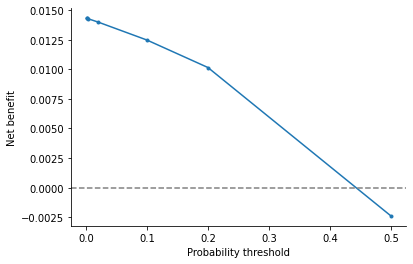

In [70]:
N = fast.sum()
ratios = [2, 5, 10, 50, 250, 500, 1000]
ps = []
nbs = []
for ratio in ratios:
    p = 1 / ratio
    net_benefit  = tp / N - fp / N * p / (1-p)
    nbs.append(net_benefit)
    ps.append(p)
plt.plot(ps, nbs, '.-')
plt.axhline(0, color='gray', ls='--')
plt.xlabel('Probability threshold')
plt.ylabel('Net benefit')
plt.show()

In [ ]:
sorted(list([x for x in d.columns if x.lower().startswith('u')]))

# net benefit on patients missed by pecarn

In [75]:
d['Age<2'] = d['Age'] < 2

In [ ]:
# can also check vars that were not used
rules = [
    ('AbdTrauma_or_SeatBeltSign', ['yes']),
    ('GCSScore', range(14)),
#     ('AbdTenderDegree', ['Mild', 'Moderate', 'Severe']),
    ('AbdTenderDegree', ['None']),    
    ('AbdTenderDegree', ['Mild']),    
    ('AbdTenderDegree', ['Moderate']),    
    ('AbdTenderDegree', ['Severe']),        
    ('ThoracicTrauma', ['yes']),        
    ('AbdomenPain', ['yes']),
    ('DecrBreathSound', ['yes']),
    ('VomitWretch', ['yes']),
    
    # not used in rule
    ('Age<2', [True]),    
    ('AbdDistention', ['yes']),
    ('MOI', ['Motor vehicle collision']),
    ('DistractingPain', ['yes']),    
    ('CostalTender', ['yes']),
    ('ThoracicTender', ['yes']),    
    ('Hypotension', ['yes']),        
    ('AbdomenTender', [1]),    
]
index = ['NA', 'IAIw/I', 'No IAIw/I', 'Difference']
o = 'iai_intervention'
r = {k + ' = ' + str(v[0]) : [] for k, v in rules}
io = d[o] == 1
print('num IwI and key / num IwI (not nan) \t num without IwI and key / num without IwI (not nane) ')
for rule in rules:
    k, vals = rule
    kk = k + ' = ' + str(vals[0])
    ik = d[k].isin(vals) # d[o]==1
    inan = d[k].isna() | (d[k] == 'unknown')
    r[kk].append(np.sum(inan))   
    num1 = np.sum(d[ik][o]==1)
    denom1 = (io & ~inan).sum()
    r[kk].append(f'{num1}/{denom1}')
    num2 = np.sum(d[ik][o]==0)
    denom2 = (~io & ~inan).sum()
    r[kk].append(f'{num2}/{denom2}')
    r[kk].append(f'{num1/denom1 - num2/denom2:0.3f}')    
r = pd.DataFrame.from_dict(r)
r.index = index
r.transpose()